Домашнее задание №7. Гарилов В.Р. 142М

In [87]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.linalg import toeplitz
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error

Моделирование измерения

In [88]:
M = 100 #размерность сигнала
noise = np.random.normal(loc=0, scale=1, size=M) #генерация шума

degree_of_smoothing = 10 #минимальное кол-во координат, учитываемых при сглаживании
basis = list(range(degree_of_smoothing, 0, -1)) + [0 for _ in range(M - degree_of_smoothing)]
B = toeplitz(basis) 

x = B @ noise
F = B @ np.transpose(B) #априорная информация
x_0 = np.zeros(M) #априорная информация

k_0 = 10 #размер окна
N = M + 2 * k_0 #размерность измерений 
filt = [1 / (2 * k_0 + 1) for _ in range(2 * k_0 + 1)] #прямоугольный фильтр
a = filt[k_0:] + [0 for _ in range(N - k_0 - 1)] 
A = toeplitz(a)[:, k_0:-k_0] #матрица A 

sigma = 0.5 #корень дисперсии шума
S = sigma ** 2 * np.eye(N) #оператор ковариации
bias = np.random.normal(loc=0, scale=sigma, size=N) #вектор шума

y = A @ x + bias #результат измерения - y

Генерация калибровочных измерений

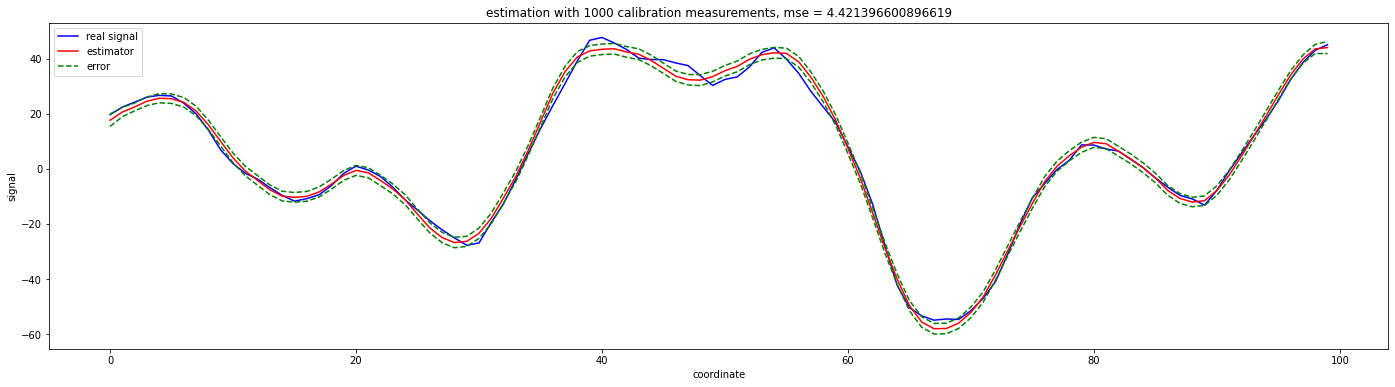

In [89]:
K = 1000 #кол-во калибровочных измерений
Psi, Phi = np.empty((N, 1)), np.empty((M, 1))
for _ in range(K):
    noise_k = np.random.normal(loc=0, scale=1, size=M) #генерация шума
    phi_k = B @ noise_k #генерация сигнала
    mu_k = np.random.normal(loc=0, scale=sigma, size=N) #вектор шума
    psi_k = A @ phi_k + mu_k #измерение
    
    phi_k = np.reshape(phi_k, (M, 1))
    psi_k = np.reshape(psi_k, (N, 1))

    Psi = np.concatenate((Psi, psi_k), axis=1)
    Phi = np.concatenate((Phi, phi_k), axis=1)

Psi = Psi[:, 1:]
Phi = Phi[:, 1:]

G = Psi @ np.transpose(Phi)
H = Phi @ np.transpose(Phi)

F_ = F + x_0 @ np.transpose(x_0)
alpha = np.trace(inv(H) @ F_)
A_0 = G @ inv(H)
Q = inv(1 / (1 + alpha) * np.transpose(A_0) @ inv(S) @ A_0 + inv(F))
estimation = Q @ (1 / (1 + alpha) * np.transpose(A_0) @ inv(S) @ y + inv(F) @ x_0)
D = np.array([np.sqrt(Q[i, i]) for i in range(len(Q))])

plt.figure(figsize=(24, 6))
plt.xlabel('coordinate')
plt.ylabel('signal')
plt.plot(np.arange(M), x, color='blue', label='real signal')
plt.plot(np.arange(M), estimation, color='red', label='estimator')
plt.plot(np.arange(M), estimation - D, color='green', label='error', ls='--')
plt.plot(np.arange(M), estimation + D, color='green', ls='--')
plt.legend()
plt.title('estimation with {0} calibration measurements, mse = {1}'.format(K, mean_squared_error(estimation, x)))
plt.show()

Добавление множественных измерений

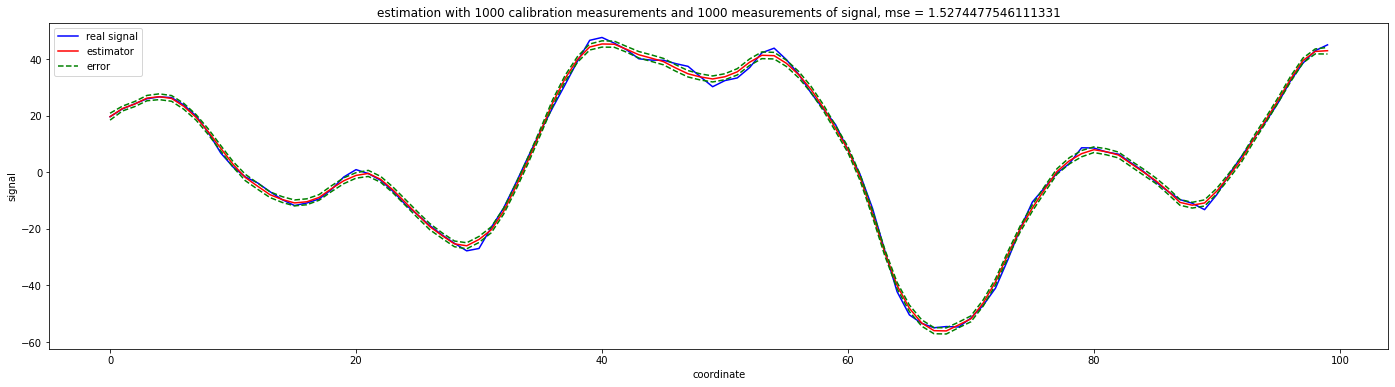

In [90]:
def foo(n=150, K=150, to_draw=False):

    y_ = np.zeros(N)
    for _ in range(n):
        nu_n = np.random.normal(loc=0, scale=sigma, size=N)
        y_n = A @ x + nu_n
        y_ += y_n

    Psi, Phi = np.empty((N, 1)), np.empty((M, 1))
    for _ in range(K):
        noise_k = np.random.normal(loc=0, scale=1, size=M) #генерация шума
        phi_k = B @ noise_k #генерация сигнала
        mu_k = np.random.normal(loc=0, scale=sigma, size=N) #вектор шума
        psi_k = A @ phi_k + mu_k #измерение
        
        phi_k = np.reshape(phi_k, (M, 1))
        psi_k = np.reshape(psi_k, (N, 1))

        Psi = np.concatenate((Psi, psi_k), axis=1)
        Phi = np.concatenate((Phi, phi_k), axis=1)

    Psi = Psi[:, 1:]
    Phi = Phi[:, 1:]

    G = Psi @ np.transpose(Phi)
    H = Phi @ np.transpose(Phi)

    F_ = F + x_0 @ np.transpose(x_0)
    alpha = np.trace(inv(H) @ F_)
    A_0 = G @ inv(H)

    Q = inv(1 / (1 / n + alpha) * np.transpose(A_0) @ inv(S) @ A_0 + inv(F))
    estimation = Q @ (1 / (1 / n + alpha) * np.transpose(A_0) @ inv(S) @ (y_ / n) + inv(F) @ x_0)
    D = np.array([np.sqrt(Q[i, i]) for i in range(len(Q))])

    if to_draw:
        plt.figure(figsize=(24, 6))
        plt.xlabel('coordinate')
        plt.ylabel('signal')
        plt.plot(np.arange(M), x, color='blue', label='real signal')
        plt.plot(np.arange(M), estimation, color='red', label='estimator')
        plt.plot(np.arange(M), estimation - D, color='green', label='error', ls='--')
        plt.plot(np.arange(M), estimation + D, color='green', ls='--')
        plt.legend()
        plt.title('estimation with {0} calibration measurements and {1} measurements of signal, mse = {2}'.format(K, n, mean_squared_error(estimation, x)))
        plt.show()

    return (estimation, D)

result = foo(n=1000, K=1000, to_draw=True)

Расчет для разных K и n

In [91]:
errors = {}

for K in [1, 100, 1000]:
    for n in [1, 100, 1000]:
        result = foo(K=K, n=n)
        errors['K = {0}, n = {1}'.format(K, n)] = mean_squared_error(result[0], x)

for key, value in errors.items():
    print('for {0} mse = {1}'.format(key, value))

for K = 1, n = 1 mse = 757.8531734039002
for K = 1, n = 100 mse = 757.8531734039351
for K = 1, n = 1000 mse = 757.8531734039841
for K = 100, n = 1 mse = 433.0801813040551
for K = 100, n = 100 mse = 86.3954876998371
for K = 100, n = 1000 mse = 75.14351427556372
for K = 1000, n = 1 mse = 3.3164762948265274
for K = 1000, n = 100 mse = 1.460533233337409
for K = 1000, n = 1000 mse = 1.2116909724421152
